# **0. PREPARATION AND LIBRARIES**

In [1]:
!pip install opendatasets

In [2]:
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 10.7 MB/s eta 0:00:00


In [3]:
import os
from google.colab import drive
from google.colab import files

In [18]:
import random
import opendatasets as od
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from ultralytics import YOLO
%matplotlib inline

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# move to preferred working directory

%cd "/content/drive/MyDrive/REA Projects/Object Detection"

/content/drive/MyDrive/REA Projects/Object Detection


In [7]:
# set working directory

HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/REA Projects/Object Detection


# **1. DOWNLOAD DATASET**

In [8]:
# download dataset with opendatasets from Kaggle

od.download("https://www.kaggle.com/datasets/slavkoprytula/aquarium-data-cots")

Skipping, found downloaded files in "./aquarium-data-cots" (use force=True to force download)


In [9]:
# define train, valid, test directories

train_images = "/content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/train/images"
train_labels = "/content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/train/labels"

valid_images = "/content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/valid/images"
valid_labels = "/content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/valid/labels"

test_images = "/content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/test/images"
test_labels = "/content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/test/labels"

yaml_path = "/content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/data.yaml"

In [10]:
# Configure YAML

%%writefile "$yaml_path"
# Path
train: /content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/train/images
val: /content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/valid/images
test: /content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/test/images

# Classes
nc: 7
names: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

Overwriting /content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/data.yaml


In [11]:
# Define the labels

classes = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}

print('Index to Label Mapping:', Idx2Label)
print('Label to Index Mapping:', Label2Index)

Index to Label Mapping: {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label to Index Mapping: {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}


# **2. EXPLORE DATASET**

In [12]:
def visualize_image_with_annotation_bboxes(image_dir, label_dir):
    # Get list of all the image files in the directory
    image_files = sorted(os.listdir(image_dir))

    # Choose 10 random image files from the list
    sample_image_files = random.sample(image_files, 12)

    # Set up the plot
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    # Loop over the random images and plot the bounding boxes
    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3

        # Load the image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load the labels for this image
        label_path = os.path.join(label_dir, image_file[:-4] + '.txt')
        f = open(label_path, 'r')

        # Loop over the labels and plot the bounding boxes
        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width/2) * w)
            y_min = int((y_center - height/2) * h)
            x_max = int((x_center + width/2) * w)
            y_max = int((y_center + height/2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, Idx2Label[int(class_id)], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

        axs[row, col].imshow(image)
        axs[row, col].axis('off')

    plt.show()

In [13]:
# Visualize 6 sample images with bounding boxes

visualize_image_with_annotation_bboxes(train_images, train_labels)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# Read a image by path
image_path = os.path.join(train_images, os.listdir(train_images)[-1])
image = cv2.imread(image_path)

# Get the size of the image
height, width, channels = image.shape
print('The image has dimensions {}x{} and {} channels'.format(height, width, channels))

The image has dimensions 1024x576 and 3 channels


# **3. TRAINING**

In [16]:
# Load a pretrained nano model
model = YOLO('yolov8n.pt')

# free up GPU memory
torch.cuda.empty_cache()

# Training the model
results = model.train(
    data= yaml_path,
    epochs = 150,
    imgsz = (height, width, channels),
    seed = 42,
    batch = 16,
    workers = 4,
    name = 'yolov8n_custom')

Ultralytics YOLOv8.0.199 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/data.yaml, epochs=150, patience=50, batch=16, imgsz=(1024, 576, 3), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=yolov8n_custom2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnosti

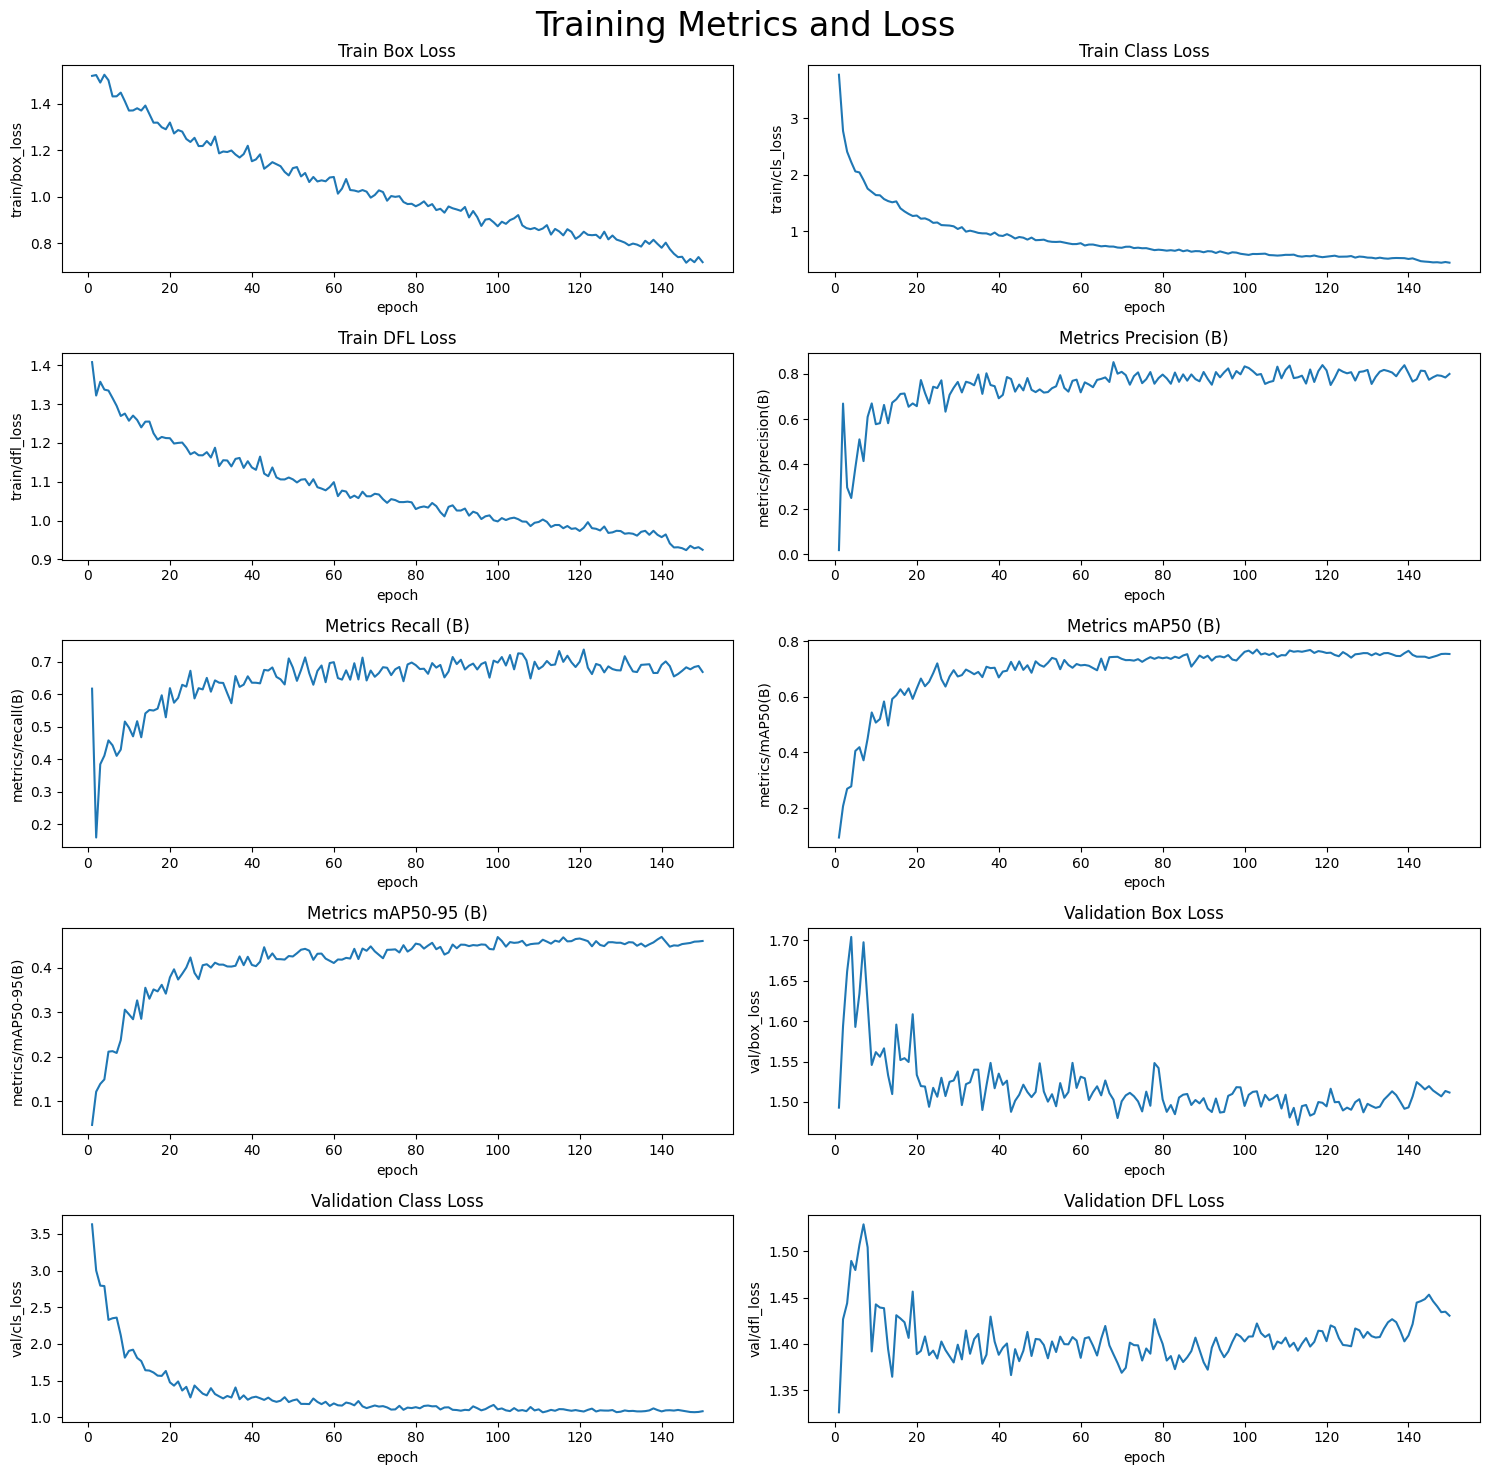

In [19]:
# plot the result

%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/REA Projects/Object Detection/runs/detect/yolov8n_custom2/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# **4. EVALUATION**

In [20]:
# Loading the best performing model
model = YOLO('/content/drive/MyDrive/REA Projects/Object Detection/runs/detect/yolov8n_custom2/weights/best.pt')

# Evaluating the model on test dataset
metrics = model.val(conf=0.25, split='test')

Ultralytics YOLOv8.0.199 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007013 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/test/labels... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:30<00:00,  2.04it/s]
val: New cache created: /content/drive/MyDrive/REA Projects/Object Detection/aquarium-data-cots/aquarium_pretrain/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]
                   all         63        584      0.886      0.681      0.799      0.526
                  fish         63        249      0.822      0.685      0.781        0.5
             jellyfish         63        154      0.887      0.792      0.867      0.608
               penguin         63         82      0.965      0.674      0.828      0.406
     

In [21]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")
print(f"Mean Average Precision @ .50   : {metrics.box.map50}")
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.5262646009332755
Mean Average Precision @ .50   : 0.7994475247618207
Mean Average Precision @ .70   : 0.5935745636206204


# **5. PREDICTION**

In [22]:
# Function to perform detections with trained model
def predict_detection(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Pass the image through the detection model and get the result
    detect_result = model(image)

    # Plot the detections
    detect_image = detect_result[0].plot()

    # Convert the image to RGB format
    detect_image = cv2.cvtColor(detect_image, cv2.COLOR_BGR2RGB)

    return detect_image

In [23]:
# Get list of all the image files in the test directory
image_files = sorted(os.listdir(test_images))

# Choose 12 random image files from the list
sample_image_files = random.sample(image_files, 12)

# Set up the plot
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# Loop over the random images and plot the detections of the trained model
for i, image_file in enumerate(sample_image_files):
    row = i // 3
    col = i % 3

    # Load the current image and run object detection
    image_path = os.path.join(test_images, image_file)
    detect_image = predict_detection(image_path)

    axs[row, col].imshow(detect_image)
    axs[row, col].axis('off')

plt.show()

Output hidden; open in https://colab.research.google.com to view.